In [582]:
import yaml
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

try:
    yaml._warnings_enabled["YAMLLoadWarning"] = False
except (KeyError, AttributeError, TypeError) as e:
    pass

In [583]:
import re
import joblib
import inspect
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse.csr import csr_matrix
from typing import List, Tuple, Union, Mapping, Any


In [584]:
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
from nltk.corpus import wordnet
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Visualization
import plotly.graph_objects as go


In [585]:
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [586]:
#data
#from scraper import get_data
#df=get_data()
#df = pd.read_csv("C:\\Users\\uriel\\OneDrive\\Desktop\\myproject\\local Uriel\\myproject\\new_try.ipynb\\spokesperson.csv")
#df.head()

In [587]:
#df.to_csv(r"C:\\Users\\uriel\\OneDrive\\Desktop\\myproject\\local Uriel\\myproject\\new_try.ipynb\\spokesperson.csv")
df = pd.read_csv("spokesperson.csv")

In [588]:
def is_question(words):
    try:
        frst2wrds = f'{words[0].lower()} {words[1].lower()}'
        first6words = ' '.join(words[0:6])
        if words[0].lower() == 'a:':
            return False

        elif words[0].lower() == 'q:':
            return True

        elif 'wang' in frst2wrds or 'zhao' in frst2wrds or 'chunying' in frst2wrds:
            return False

        elif ':' in first6words:
            return True
            
        else:
            return False
    except:
        pass

In [589]:
def qa_sort(df):
    dialog_no = 0
    data = []
    for row in df.itertuples():
        words = row[3].split()
        result = is_question(words)
        if result == True:
                dialog_no +=1
        data.append([row[3] , result, dialog_no])
    qa_df = pd.DataFrame(data , columns=['text' , 'question' , 'dialog_id'])
    return qa_df

In [590]:
qa_df = qa_sort(df)
df['question'] = qa_df['question']
df['dialog_id'] = qa_df['dialog_id']

In [591]:
for i in range(len(df)):
    df['date'][i] = datetime.datetime.strptime(df['date'][i], '%Y-%m-%d')
type(df['date'].iloc[1])

datetime.datetime

In [592]:
# documents = df[['text']]
cut_date = '2021-09-30'
cut_date_datetime = datetime.datetime.strptime(cut_date, '%Y-%m-%d')
documents = df[["date","text"]][~(df['date'] < cut_date_datetime)]
documents["index"] = range(len(documents['text']))
documents.head()

#documents = df[['text']].head(200)


#print(len(documents))

,date,text,index
0,2021-12-22 00:00:00,China Daily: As we are getting closer to the o...,0
1,2021-12-22 00:00:00,Zhao Lijian: The idea of a green Beijing 2022 ...,1
2,2021-12-22 00:00:00,"In recent years, Beijing and Hebei province ha...",2
3,2021-12-22 00:00:00,"During the Games, all 12 Olympic venues will b...",3
4,2021-12-22 00:00:00,"Lately, many people in the international commu...",4


In [593]:
from collections import Counter
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import matplotlib.pyplot as plt
import wordcloud as WordCloud
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import os
import umap.plot
import matplotlib.patches as mpatches

In [594]:
#Defining all functions

def get_topic_words(token_list, labels, k=None):
  ''' Get topic within each topic form clustering results '''
  if k is None:
    k = len(np.unique(labels))
  #index_k_list = [*range(0,k,1)]
  topics = ['' for _ in range(k)]
  for i, c in enumerate(token_list):
    topics[labels[i]] += (' ' + ' '.join(c))
  word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
  # get sorted word counts
  word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True),word_counts))
  # get topics
  topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))
  
  return topics

def get_coherence(model, token_lists, measure='c_v'):
  ''' Get model coherence from gensim.models.coherencemodel
  : param model: Topic_Model object
  : param token_lists: token list of docs
  : param topics: topics as top words 
  : param measure: coherence metrics
  : return: coherence score '''

  if model.method == 'LDA':
    cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus = model.corpus, dictionary=model.dictionary, coherence = measure)
  else:
    topics = get_topic_words(token_lists, model.cluster_model.labels_)
    cm = CoherenceModel(topics=topics, texts = token_lists, corpus=model.corpus, dictionary=model.dictionary, coherence = measure)
    return cm.get_coherence()

def get_silhouette(model):
  ''' Get silhoulette score from model
  :param_model: Topic_model score
  :return: silhoulette score '''            
  if model.method == 'LDA':
    return
  lbs = model.cluster_model.labels_
  vec = model.vec[model.method]
  return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
  '''
  Plot UMAP embeddings
  :param embedding: UMAP (or other) embeddings
  :param lbs: labels
  '''
  n = len(embedding)
  counter = Counter(lbs)
  fig1 = plt.figure("Clustered statements", figsize=(8, 6), dpi=80)
  for i in range(len(np.unique(lbs))):
    plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5, label='cluster {}: {:.2f}%'.format(i, counter[i] / n*100))
    plt.legend(loc='best')
    plt.grid(color='grey', linestyle='-', linewidth=0.25)
  plt.show()
  
  

def visualize(model):  ## added token_list, topic
  '''
  Visualize the result for the topic model by 2D embedding (UMAP)
  :param model: Topic_Model object
  '''
  if model.method == 'LDA':
      
    return
  reducer = umap.UMAP(n_components=2, metric='hellinger')
  print('Calculating UMAP projection...')
  vec_umap = reducer.fit_transform(model.vec[model.method])  
  print(vec_umap)             
  print('Calculating the Umap projection. Done!')
  plot_proj(vec_umap, model.cluster_model.labels_) 

 
  
  #umap.plot.points(vec_umap, labels= model.cluster_model.labels_ , theme='fire')   
  #plt.legend()

def get_wordcloud(model, token_list, topic):
  """
  Get word cloud of each topic from fitted model
  :param model: Topic_Model object
  :param sentences: preprocessed sentences from docs
  """
  if model.method == 'LDA':
    return
  lbs = model.cluster_model.labels_
  tokens = ' '.join([' '.join(_) for _ in np.array(token_list)[lbs == topic   ]])
  wordcloud = WordCloud.WordCloud(width=800, height=560, background_color='white', collocations=False, min_font_size=10).generate(tokens)
  # plot the WordCloud image
  print('Word cloud for topic {}... '.format(topic))
  plt.figure(figsize=(8, 5.6), facecolor=None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad=0)
  print('Getting wordcloud for topic {}. Done!'.format(topic))

In [595]:
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
from language_detector import detect_language

import pkg_resources
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

In [596]:
##sentences preprocess
def f_base(s):
    """
    :param s: string to be processed
    :return: processed string
    """
    # normalization 1: xxxThis is a --> xxx. This is a (missing delimiter)
    s = re.sub(r'([a-z])([A-Z])', r'\1\. \2', s)  # before lower case
    # normalization 2: lower case
    s = s.lower()
    # normalization 3: "&gt", "&lt"
    s = re.sub(r'&gt|&lt', ' ', s)
    # normalization 4: letter repetition (if more than 2)
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # normalization 5: non-word repetition (if more than 1)
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # normalization 6: string * as delimiter
    s = re.sub(r'\*|\W\*|\*\W', '. ', s)
    # normalization 7: stuff in parenthesis, assumed to be less informal
    s = re.sub(r'\(.*?\)', '. ', s)
    # normalization 8: xxx[?!]. -- > xxx.
    s = re.sub(r'\W+?\.', '.', s)
    # normalization 9: [.?!] --> [.?!] xxx
    s = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', s)
    # normalization 10: ' ing ', noise text
    s = re.sub(r' ing ', ' ', s)
    # normalization 11: noise text
    s = re.sub(r'product received for free[.| ]', ' ', s)
    # normalization 12: phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()




In [597]:
# language detection
def f_lan(s):
    """
    :param s: string to be processed
    :return: boolean (s is English)
    """

    # some reviews are actually english but biased toward Chinese
    return detect_language(s) in {'English','Chinese'}


In [598]:
#### word level preprocess 


# filtering out punctuations and numbers
def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]


# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


# typo correction
def f_typo(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
            # do word segmentation, deprecated for inefficiency
            # w_seg = sym_spell.word_segmentation(phrase=word)
            # w_list_fixed.extend(w_seg.corrected_string.split())
    return w_list_fixed

In [599]:
# stemming
# p_stemmer = PorterStemmer()


# def f_stem(w_list):
#     """
#     :param w_list: word list to be processed
#     :return: w_list with stemming
#     """
#     return [p_stemmer.stem(word) for word in w_list]

In [600]:
# filtering out stop words
# create English stop words list

stop_words = (list(
    set(get_stop_words('en'))
    |set(get_stop_words('es'))
    |set(get_stop_words('de'))
    |set(get_stop_words('it'))
    |set(get_stop_words('ca'))
    |set(get_stop_words('pt'))
    |set(get_stop_words('pl'))
    |set(get_stop_words('da'))
    |set(get_stop_words('ru'))
    |set(get_stop_words('sv'))
    |set(get_stop_words('sk'))
    |set(get_stop_words('nl'))
))

def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]


def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw review texts
    :param rw: review to be processed
    :return: sentence level pre-processed review
    """
    s = f_base(rw)
    if not f_lan(s):
        return None
    return s


def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    including: remove punctuation, select noun, fix typo, stem, stop_words
    :param s: sentence to be processed
    :return: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    w_list = f_noun(w_list)
    w_list = f_typo(w_list)
    #w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list

In [601]:
##Autoencoders##

import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [602]:
class Autoencoder:
  """
  Autoencoder for learning latent space representation
  architecture simplified for only one hidden layer
  """
  def __init__(self, latent_dim = 32, activation='relu', epochs=200, batch_size=128):
    self.latent_dim = latent_dim
    self.activation = activation
    self.epochs = epochs
    self.batch_size = batch_size
    self.autoencoder = None
    self.encoder = None
    self.decoder = None
    self.his = None

  def _compile(self, input_dim):
    '''
    compile the computational graph
    '''
    input_vec = Input(shape=(input_dim,))
    encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
    decoded = Dense(input_dim, activation=self.activation)(encoded)
    self.autoencoder = Model(input_vec, decoded)
    self.encoder = Model(input_vec, encoded)
    encoded_input = Input(shape=(self.latent_dim,))
    decoder_layer = self.autoencoder.layers[-1]
    self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
    self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

  def fit(self, X):
      if not self.autoencoder:
        if type(X) == list:
          X = np.asarray(X)
        self._compile(X.shape[1])
      X_train, X_test = train_test_split(X)
      self.his = self.autoencoder.fit(X_train, X_train, epochs=200, batch_size=128, shuffle=True, validation_data=(X_test, X_test), verbose=0)

In [603]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim
import numpy as np
#from Autoencoder import *
#from preprocess import *
from datetime import datetime

In [604]:
def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    #     samp = list(range(100))
    samp = np.random.choice(n_docs, samp_size)
    for i, idx in enumerate(samp):
        sentence = preprocess_sent(docs[idx])
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists, idx_in


# define model object
class Topic_Model:
    def __init__(self, k=20, method='LDA_BERT'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

             
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

In [605]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('averaged_perceptron_tagger')
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=Warning)

import argparse

#def model(): #:if __name__ == '__main__':

def main():
    
    
    method = "LDA_BERT"
    samp_size = len(documents)
    ntopic = 10
    

    data = documents 
    data = data.fillna('')  # only the comments has NaN's
    sentences, token_lists, idx_in = preprocess(documents['text'], samp_size=samp_size)
    # Define the topic model object
    tm = Topic_Model(k = ntopic, method = method)
    # Fit the topic model by chosen method
    tm.fit(sentences, token_lists)
    # Evaluate using metrics
    print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
    print('Silhouette Score:', get_silhouette(tm))
    #print('Topic Words:' , get_topic_words(token_lists, tm.cluster_model.labels_, k=ntopic))
    outside_topics = get_topic_words(token_lists, tm.cluster_model.labels_, k=ntopic) 
    df_topics = pd.DataFrame({'Most important Words':outside_topics})
    df_assigned_topic = pd.DataFrame({'Assigned topic':tm.cluster_model.labels_})
    df_assigned_topic['index'] = range(len(df_assigned_topic))
    documents_merged = documents.merge(df_assigned_topic, on='index', how='left')
    print(df_topics)
    print(documents_merged.columns)  
    print(documents_merged.shape) 
                            ######show when need to print#######
    #print(df_assigned_topic.value_counts())    ######show when need to print#######
    sns.set(font_scale=1.4)
    fig2 = plt.figure("Counting statements", figsize=(8, 6), dpi=80)
    documents_merged['Assigned topic'].value_counts().plot(kind = 'bar')###############add to csv
    plt.xlabel("Topic number", labelpad=14)
    plt.ylabel("Count of statments", labelpad=14)
    plt.title("Count of Topics among statments")
    plt.show
    
    # visualize and save img
    visualize(tm)
    for i in range(tm.k):      # deleted line
        get_wordcloud(tm, token_lists, i)
        print('\n')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uriel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\uriel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Preprocessing raw texts ...
Preprocessing raw texts. Done!
Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Batches: 100%|██████████| 67/67 [04:07<00:00,  3.70s/it]


Getting vector representations for BERT. Done!
Fitting Autoencoder ...
Fitting Autoencoder Done!
Clustering embeddings. Done!
Coherence: 0.4495021380010179
Silhouette Score: 0.1517451
                                Most important Words
0  [china, comment, minister, countries, ministry...
1  [china, power, year, situation, information, p...
2  [china, cooperation, countries, meeting, devel...
3  [china, cooperation, development, countries, r...
4  [olympic, winter, beijing, games, countries, c...
5  [rights, president, countries, china, meeting,...
6  [countries, democracy, china, world, vaccines,...
7  [cooperation, countries, weapons, china, parti...
8  [kong, hong, china, people, rights, comment, l...
9  [china, countries, side, community, developmen...
Index(['date', 'text', 'index', 'Assigned topic'], dtype='object')
(2242, 4)
Calculating UMAP projection...
[[ 3.5396552  9.164688 ]
 [ 5.976504  13.367873 ]
 [ 0.4737338 11.381015 ]
 ...
 [ 2.4893532 13.222014 ]
 [ 5.175555  13.6896

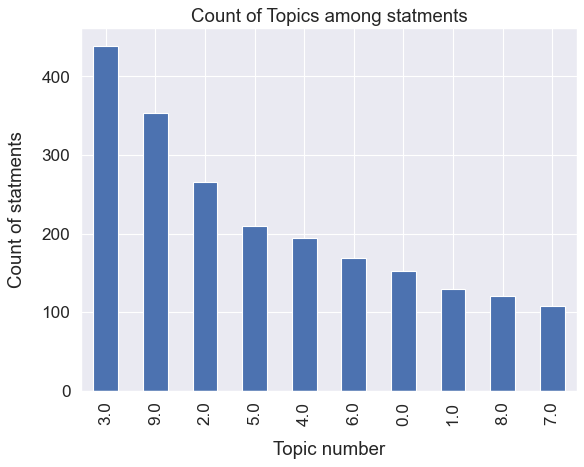

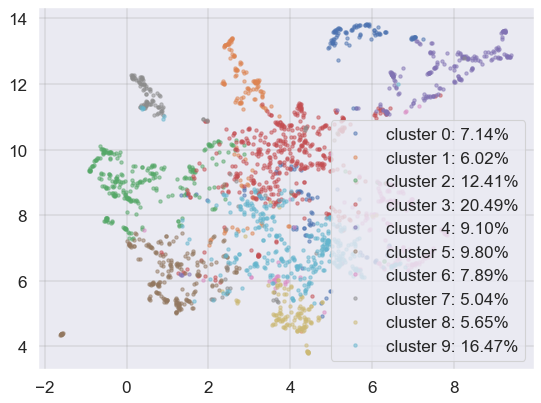

Word cloud for topic 0... 
Getting wordcloud for topic 0. Done!


Word cloud for topic 1... 
Getting wordcloud for topic 1. Done!


Word cloud for topic 2... 
Getting wordcloud for topic 2. Done!


Word cloud for topic 3... 
Getting wordcloud for topic 3. Done!


Word cloud for topic 4... 
Getting wordcloud for topic 4. Done!


Word cloud for topic 5... 
Getting wordcloud for topic 5. Done!


Word cloud for topic 6... 
Getting wordcloud for topic 6. Done!


Word cloud for topic 7... 
Getting wordcloud for topic 7. Done!


Word cloud for topic 8... 
Getting wordcloud for topic 8. Done!


Word cloud for topic 9... 
Getting wordcloud for topic 9. Done!




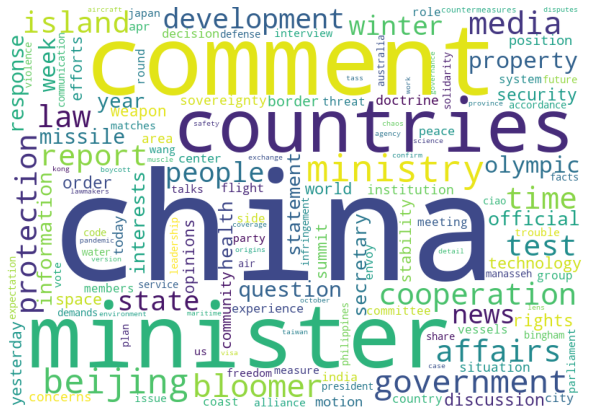

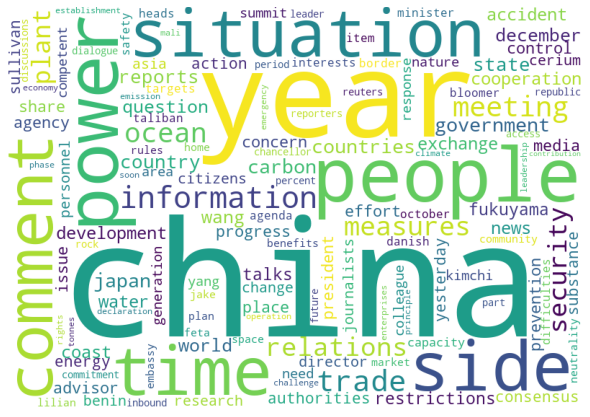

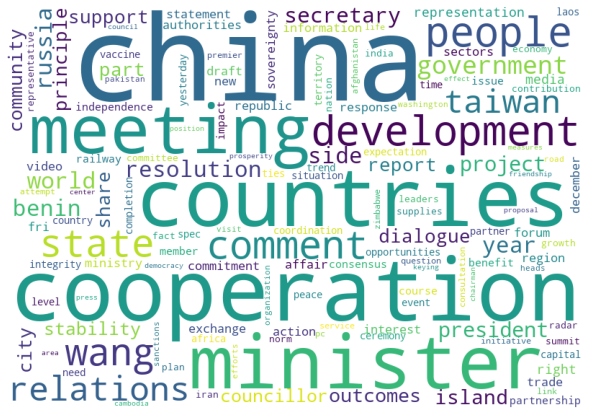

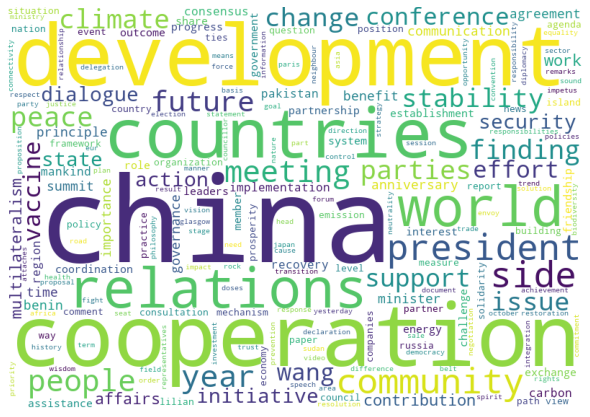

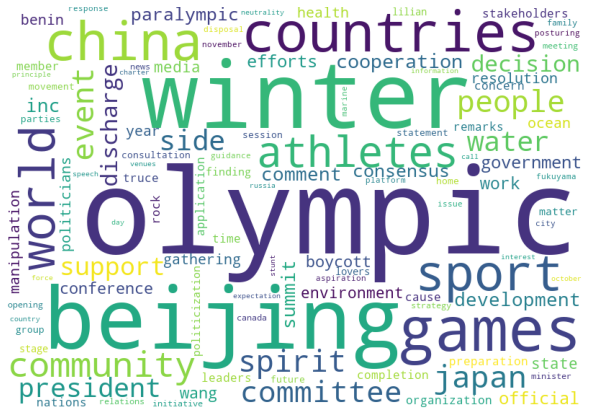

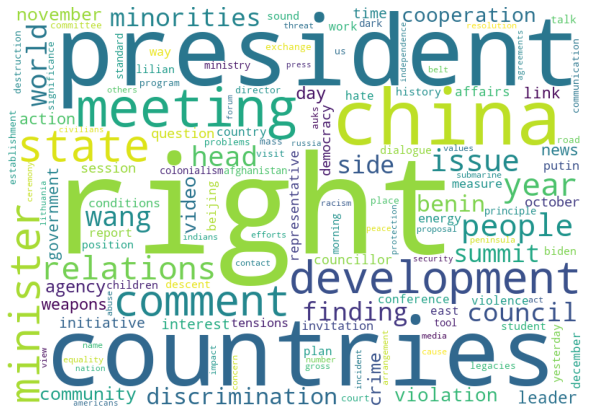

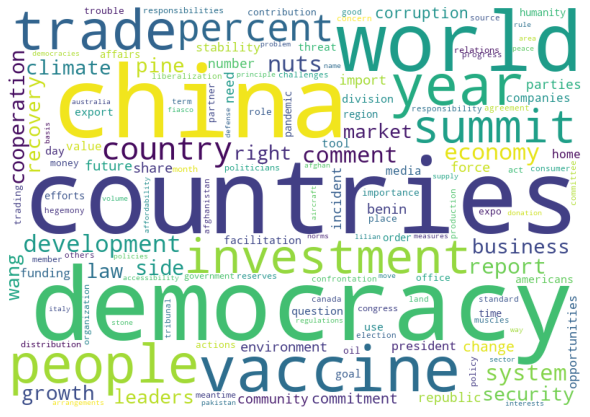

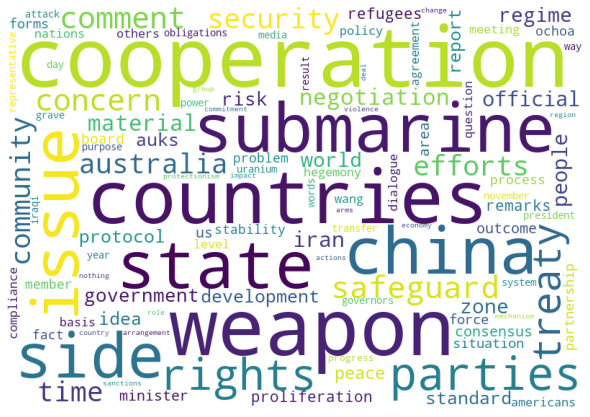

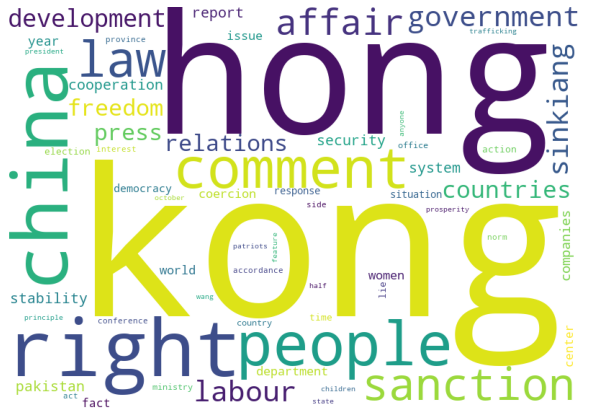

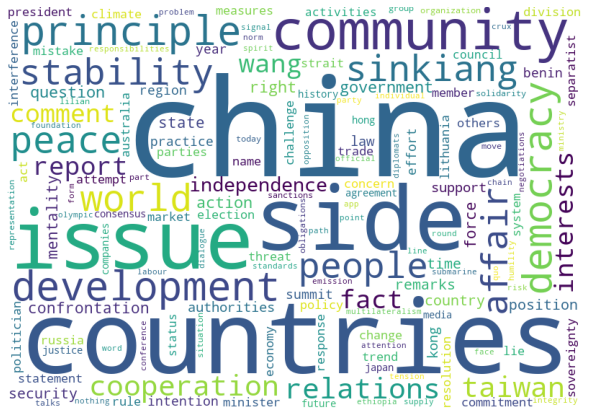

In [606]:
main()